In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
import os
import random

seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Normalisation des images pour les modèles pré-entraînés PyTorch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_directory = "/content/gdrive/MyDrive/GitHub/ProjetFromage/augmentated_data/train/"
test_directory = "/content/gdrive/MyDrive/GitHub/ProjetFromage/augmentated_data/test/"
dataset_train_full = datasets.ImageFolder(train_directory, data_transforms)
dataset_test = datasets.ImageFolder(test_directory, data_transforms)

# split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_val = train_test_split(dataset_train_full.samples,test_size=0.2)
samples_test = dataset_test.samples

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 13728
Nombre d'images de val : 3432
Nombre d'images de test : 954


In [ ]:
BATCH_SIZE = 8

# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
dataset_train = datasets.ImageFolder(train_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

dataset_val = datasets.ImageFolder(train_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

torch.manual_seed(42)

In [ ]:
# détermination du nombre de classes
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 43 classes


In [ ]:
# on définit le device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [ ]:
# on définit une fonction d'évaluation
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

# fonction d'entraînement du modèle
PRINT_LOSS = False

def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10, scheduler=None):
  
    since = time.time()
    best_acc=0
    best_model_wts = copy.deepcopy(model.state_dict())
    saved_acc=[]
    lrs=[]

    for epoch in range(n_epochs): 
        batch=0
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train):
            batch+=1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels) 
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val)
                model.train(True)
                #print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() 
            optimizer.step() 
            lrs.append(optimizer.param_groups[0]["lr"])
            if scheduler:
              scheduler.step()
            #print(f'Batch {batch} : {optimizer.param_groups[0]["lr"]}')

        model.train(False)
        loss_val, accuracy = evaluate(model, data_val)
        saved_acc.append(accuracy)
        #early stopping
        if accuracy>best_acc:
          best_acc=accuracy
          best_model_wts = copy.deepcopy(model.state_dict())
        model.train(True)
        print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))

    plt.plot(lrs)
    model.load_state_dict(best_model_wts)
    return best_acc


Apprentissage en transfer learning
EPOCH  0
1715 loss train: 2.6086	 val 0.0936	Acc (val): 59.9%
EPOCH  1
1715 loss train: 1.4371	 val 0.0839	Acc (val): 63.0%
EPOCH  2
1715 loss train: 1.0353	 val 0.0852	Acc (val): 62.1%
EPOCH  3
1715 loss train: 1.7733	 val 0.0838	Acc (val): 63.4%
EPOCH  4
1715 loss train: 1.4606	 val 0.0766	Acc (val): 67.0%
EPOCH  5
1715 loss train: 1.1267	 val 0.0694	Acc (val): 69.3%
EPOCH  6
1715 loss train: 1.0054	 val 0.0682	Acc (val): 70.3%
EPOCH  7
1715 loss train: 1.3177	 val 0.0672	Acc (val): 71.6%
EPOCH  8
1715 loss train: 1.1811	 val 0.0703	Acc (val): 69.8%
EPOCH  9
1715 loss train: 1.3429	 val 0.0753	Acc (val): 67.5%
Accuracy (test): 64.2%


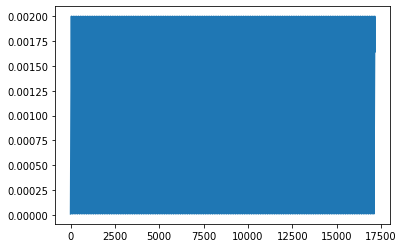

In [ ]:
#===== Transfer learning "simple" (sans fine tuning) =====

my_net = models.resnet18(pretrained=True)
weight_decay = 0

for param in my_net.parameters():
    param.requires_grad = False

my_net.fc = nn.Linear(in_features=my_net.fc.in_features, out_features=nb_classes, bias=True)
my_net.to(device) 
my_net.train(True) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_net.fc.parameters(), lr=0.001, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.002, step_size_up=50, mode="triangular", cycle_momentum=False)

print("Apprentissage en transfer learning")
my_net.train(True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10, scheduler=scheduler)

# évaluation
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

PATH="/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetTL_weights.pth"
torch.save(my_net.state_dict(), PATH)
torch.save(my_net, "/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetTL_model.pth")

Apprentissage avec fine-tuning
EPOCH  0
1715 loss train: 1.4486	 val 0.0454	Acc (val): 79.6%
EPOCH  1
1715 loss train: 0.2221	 val 0.0251	Acc (val): 88.2%
EPOCH  2
1715 loss train: 0.1651	 val 0.0188	Acc (val): 91.3%
EPOCH  3
1715 loss train: 0.1187	 val 0.0182	Acc (val): 92.1%
EPOCH  4
1715 loss train: 0.2175	 val 0.0159	Acc (val): 93.2%
EPOCH  5
1715 loss train: 0.0111	 val 0.0154	Acc (val): 93.5%
EPOCH  6
1715 loss train: 0.0037	 val 0.0141	Acc (val): 93.7%
EPOCH  7
1715 loss train: 0.0115	 val 0.0138	Acc (val): 94.1%
EPOCH  8
1715 loss train: 0.0066	 val 0.0141	Acc (val): 94.3%
EPOCH  9
1715 loss train: 0.0125	 val 0.0136	Acc (val): 94.1%
Accuracy (test): 80.3%


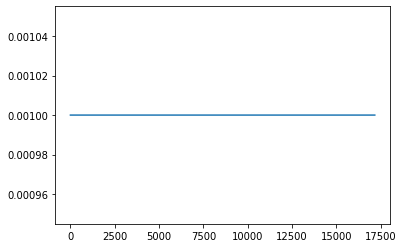

In [ ]:
#===== Fine tuning =====

# on réinitialise resnet
my_net_ft = models.resnet18(pretrained=True)
weight_decay = 0.0001

my_net_ft.fc = nn.Linear(in_features=my_net_ft.fc.in_features, out_features=nb_classes, bias=True)
my_net_ft.to(device)

# cette fois on veut updater tous les paramètres
params_to_update = my_net_ft.parameters()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9, weight_decay=weight_decay)

# on ré-entraîne
print("Apprentissage avec fine-tuning")
my_net_ft.train(True)
torch.manual_seed(42)
train_model(my_net_ft, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# on ré-évalue les performances
my_net_ft.train(False)
loss, accuracy = evaluate(my_net_ft, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

PATH="/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetFT_weights.pth"
torch.save(my_net_ft.state_dict(), PATH)
torch.save(my_net_ft, "/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetFT_model.pth")

In [ ]:
new_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetFT_model.pth")
criterion = nn.CrossEntropyLoss()
loss, accuracy = evaluate(new_model, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

new_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetTL_model.pth")
criterion = nn.CrossEntropyLoss()
loss, accuracy = evaluate(new_model, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

new_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/MobileNetTL_model.pth")
criterion = nn.CrossEntropyLoss()
loss, accuracy = evaluate(new_model, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))



Accuracy (test): 80.3%
Accuracy (test): 64.2%
Accuracy (test): 68.7%
